# IEEE-CIS Fraud Detection

Can you detect fraud from customer transactions?

The competition: https://www.kaggle.com/c/ieee-fraud-detection

In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import math

In [3]:
ASSETS_PATH = './assets/'

## Load data

Firstly, create function to optimize memory for loading the data

In [8]:
# From: https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024 ** 2
    print("Memory usage of properties dataframe is :", start_mem_usg, " MB")
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            IsInt = False

            mx = props[col].max()
            mn = props[col].min()

            if not np.isfinite(props[col]).all():
                props[col].fillna(-999, inplace=True)

            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()

            if -0.01 < result < 0.01:
                IsInt = True

            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)
            else:
                props[col] = props[col].astype(np.float32)

    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024 ** 2
    print("Memory usage is: ", mem_usg, " MB")
    print("This is ", 100 * mem_usg / start_mem_usg, "% of the initial size")
    return props

def load_csv(path):
    return reduce_mem_usage(pd.read_csv(path))

### Load the test & train data

In [9]:
train_identity = load_csv(f'{ASSETS_PATH}/train_identity.csv')
train_transaction = load_csv(f'{ASSETS_PATH}/train_transaction.csv')
test_identity = load_csv(f'{ASSETS_PATH}/test_identity.csv')
test_transaction = load_csv(f'{ASSETS_PATH}/test_transaction.csv')

Memory usage of properties dataframe is : 45.116905212402344  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  23.934003829956055  MB
This is  53.04885988362684 % of the initial size
Memory usage of properties dataframe is : 1775.152359008789  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  450.5463409423828  MB
This is  25.38071386694713 % of the initial size
Memory usage of properties dataframe is : 44.389320373535156  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  23.54802894592285  MB
This is  53.04886118500284 % of the initial size
Memory usage of properties dataframe is : 1519.2380752563477  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  376.9102668762207  MB
This is  24.80916408131905 % of the initial size


## Visualizations

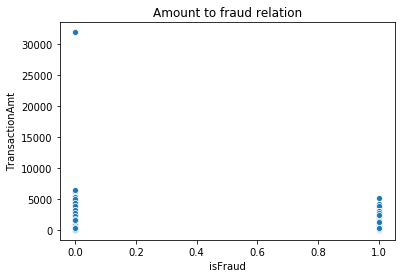

In [10]:
plt.title('Amount to fraud relation')
sns.scatterplot(x='isFraud', y='TransactionAmt', data=train_transaction)
plt.show()

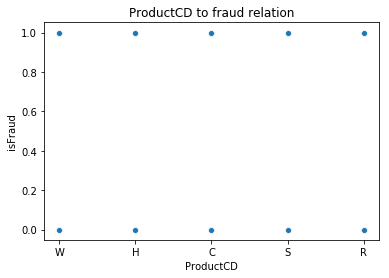

In [11]:
plt.figure()
plt.title('ProductCD to fraud relation')
sns.scatterplot(x='ProductCD', y='isFraud', data=train_transaction)
plt.show()

## Join transactions with identities

In [140]:
train_df = reduce_mem_usage(pd.merge(train_transaction, train_identity, on='TransactionID', how='left'))
test_df = reduce_mem_usage(pd.merge(test_transaction, test_identity, on='TransactionID', how='left'))

Memory usage of properties dataframe is : 633.0175018310547  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  550.7928085327148  MB
This is  87.01067615658363 % of the initial size
Memory usage of properties dataframe is : 533.4728851318359  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  462.92302894592285  MB
This is  86.77536231884058 % of the initial size


## Save train & test DF as pickle files

In [13]:
with open(f'{ASSETS_PATH}/train_df.pickle', 'wb') as f:
    pickle.dump(train_df, f, pickle.HIGHEST_PROTOCOL)
    
with open(f'{ASSETS_PATH}/test_df.pickle', 'wb') as f:
    pickle.dump(test_df, f, pickle.HIGHEST_PROTOCOL)

## Load train & test DF from pickle files

In [14]:
with open(f'{ASSETS_PATH}/train_df.pickle', 'rb') as f:
    train_df = pickle.load(f)
    
with open(f'{ASSETS_PATH}/test_df.pickle', 'rb') as f:
    test_df = pickle.load(f)

### Prepare categorical & numerical columns

**Categorical Features in Transaction**
- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

**Categorical Features in Identity**
- DeviceType
- DeviceInfo
- id_12 - id_38

In [15]:
CATEGORICAL_COLS = 'id_1\d|id_2\d|id_3\d|card|ProductCD|add|email|M|DeviceType|DeviceInfo'
categorical_columns = train_df.filter(regex=CATEGORICAL_COLS).drop(columns=['id_10', 'id_11']).columns
numerical_columns = train_df.drop(columns=[*categorical_columns, 'TransactionID', 'isFraud']).columns

### List columns

In [16]:
print('Categorical columns: ', list(categorical_columns))
print('Numerical columns: ', list(numerical_columns))

Categorical columns:  ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
Numerical columns:  ['TransactionDT', 'TransactionAmt', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V4

### List head from the train dataset

In [141]:
train_df.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,64537,150,discover,142,...,NaN,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404,150,mastercard,102,...,NaN,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490,150,visa,166,...,NaN,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567,150,mastercard,117,...,NaN,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514,150,mastercard,102,...,samsung browser 6.2,32,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
5,2987005,0,86510,49.0,W,5937,555,150,visa,226,...,NaN,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.0,W,12308,360,150,visa,166,...,NaN,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.5,W,12695,490,150,visa,226,...,NaN,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.0,H,2803,100,150,visa,226,...,mobile safari 11.0,32,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
9,2987009,0,86536,117.0,W,17399,111,150,mastercard,224,...,NaN,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Normalize numerical columns

In [142]:
for column in numerical_columns:
    column_df = pd.concat([train_df[column], test_df[column]])
    column_df = (column_df - column_df.min()) / (column_df.max() - column_df.min())
    train_df[column] = column_df[:len(train_df)]
    test_df[column] = column_df[len(train_df):]

/home/simon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in byte_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


### Encode categorical data

Based on idea from: https://www.kaggle.com/c/ieee-fraud-detection/discussion/108575#latest-627291

In [143]:
for column in categorical_columns:
    column_df = pd.concat([train_df[column], test_df[column]])
    column_df, _ = column_df.factorize()

    if column_df.max() < 128:
        column_df = column_df.astype('int8')
    elif column_df.max() < 32768:
        column_df = column_df.astype('int16')
    else:
        column_df.astype('int32')

    train_df[column] = column_df[:len(train_df)]
    test_df[column] = column_df[len(train_df):]

#### List categorical dataset

In [144]:
train_df[categorical_columns].head(10)

,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,0,0,0,0,0,0,0,0,-1,...,-1,0,-1,-1,-1,-1,-1,-1,-1,-1
1,0,1,1,0,1,1,0,1,0,0,...,-1,0,-1,-1,-1,-1,-1,-1,-1,-1
2,0,2,2,0,2,2,1,2,0,1,...,-1,0,-1,-1,-1,-1,-1,-1,-1,-1
3,0,3,3,0,1,3,1,3,0,2,...,-1,0,-1,-1,-1,-1,-1,-1,-1,-1
4,1,4,4,0,1,1,0,4,0,0,...,0,1,0,0,0,0,0,0,0,0
5,0,5,5,0,2,4,1,5,0,0,...,-1,0,-1,-1,-1,-1,-1,-1,-1,-1
6,0,6,6,0,2,2,1,6,0,2,...,-1,0,-1,-1,-1,-1,-1,-1,-1,-1
7,0,7,2,0,2,4,1,1,0,3,...,-1,0,-1,-1,-1,-1,-1,-1,-1,-1
8,1,8,7,0,2,4,1,7,0,4,...,1,1,1,1,0,0,1,0,0,1
9,0,9,8,0,1,5,1,8,0,2,...,-1,0,-1,-1,-1,-1,-1,-1,-1,-1


#### List numerical dataset

In [145]:
train_df[numerical_columns].head(10)

,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,...,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11
0,0.000000e+00,0.002144,0.000294,1.0,0.000015,0.000015,0.0,0.0,0.0,0.000015,...,1.000000,1.0,1.0,-0.861789,1.00,0.663551,1.0,1.0,1.0,0.0
1,2.930150e-08,0.000907,1.000000,1.0,0.000015,0.000015,0.0,0.0,0.0,0.000015,...,1.000000,1.0,1.0,-0.861789,1.00,0.663551,1.0,1.0,1.0,0.0
2,2.021804e-06,0.001847,0.004447,1.0,0.000015,0.000015,0.0,0.0,0.0,0.000015,...,1.000000,1.0,1.0,-0.861789,1.00,0.663551,1.0,1.0,1.0,0.0
3,2.900849e-06,0.001565,1.000000,1.0,0.000031,0.000077,0.0,0.0,0.0,0.000062,...,1.000000,1.0,1.0,-0.861789,1.00,0.663551,1.0,1.0,1.0,0.0
4,3.105959e-06,0.001565,1.000000,1.0,0.000015,0.000015,0.0,0.0,0.0,0.000015,...,0.000016,1.0,1.0,-0.861789,1.00,0.663551,1.0,1.0,1.0,1.0
5,3.223165e-06,0.001534,0.000558,1.0,0.000015,0.000015,0.0,0.0,0.0,0.000015,...,1.000000,1.0,1.0,-0.861789,1.00,0.663551,1.0,1.0,1.0,0.0
6,3.574783e-06,0.004978,0.000000,1.0,0.000015,0.000015,0.0,0.0,0.0,0.000015,...,1.000000,1.0,1.0,-0.861789,1.00,0.663551,1.0,1.0,1.0,0.0
7,3.779894e-06,0.013228,1.000000,1.0,0.000015,0.000015,0.0,0.0,0.0,0.000015,...,1.000000,1.0,1.0,-0.861789,1.00,0.663551,1.0,1.0,1.0,0.0
8,3.955703e-06,0.000469,1.000000,1.0,0.000015,0.000015,0.0,0.0,0.0,0.000015,...,0.000023,1.0,1.0,-0.658537,0.76,0.663551,1.0,1.0,1.0,1.0
9,3.985004e-06,0.003663,0.000294,1.0,0.000031,0.000031,0.0,0.0,0.0,0.000046,...,1.000000,1.0,1.0,-0.861789,1.00,0.663551,1.0,1.0,1.0,0.0


In [148]:
test_df[numerical_columns].head(10)

,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,...,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11
0,0.536710,0.001000,0.000015,1.0,0.000093,0.000093,0.0,0.0,0.000046,0.000062,...,1.0,1.0,1.0,-0.861789,1.0,0.663551,1.0,1.0,1.0,0.0
1,0.536712,0.001534,0.000062,1.0,0.000046,0.000031,0.0,0.0,0.000000,0.000015,...,1.0,1.0,1.0,-0.861789,1.0,0.663551,1.0,1.0,1.0,0.0
2,0.536713,0.005354,0.040829,1.0,0.000031,0.000031,0.0,0.0,0.000000,0.000077,...,1.0,1.0,1.0,-0.861789,1.0,0.663551,1.0,1.0,1.0,0.0
3,0.536713,0.008922,0.000263,1.0,0.000077,0.000031,0.0,0.0,0.000015,0.000015,...,1.0,1.0,1.0,-0.861789,1.0,0.663551,1.0,1.0,1.0,0.0
4,0.536713,0.002127,0.000093,1.0,0.000093,0.000093,0.0,0.0,0.000031,0.000077,...,1.0,1.0,1.0,-0.861789,1.0,0.663551,1.0,1.0,1.0,0.0
5,0.536713,0.001814,1.000000,1.0,0.000077,0.000077,0.0,0.0,0.000031,0.000046,...,1.0,1.0,1.0,-0.861789,1.0,0.663551,1.0,1.0,1.0,0.0
6,0.536714,0.002724,1.000000,1.0,0.000015,0.000015,0.0,0.0,0.000000,0.000015,...,1.0,1.0,1.0,-0.861789,1.0,0.663551,1.0,1.0,1.0,0.0
7,0.536715,0.012211,0.004695,1.0,0.000046,0.000015,0.0,0.0,0.000000,0.000015,...,1.0,1.0,1.0,-0.861789,1.0,0.663551,1.0,1.0,1.0,0.0
8,0.536716,0.003254,0.000046,1.0,0.002355,0.002293,0.0,0.0,0.002092,0.001472,...,1.0,1.0,1.0,-0.861789,1.0,0.663551,1.0,1.0,1.0,0.0
9,0.536716,0.003663,0.000124,1.0,0.000031,0.000031,0.0,0.0,0.000000,0.000015,...,1.0,1.0,1.0,-0.861789,1.0,0.663551,1.0,1.0,1.0,0.0


### Split train df to X and y

In [146]:
train_df_X = train_df.drop(columns=['isFraud'])
train_df_y = train_df['isFraud']
train_X, test_X, train_y, test_y = train_test_split(train_df_X, train_df_y, test_size=.2)

### Logistic regression model

Definition & training

In [147]:
lr_model = LogisticRegression(solver='saga', max_iter=20, n_jobs=-1, verbose=1)
lr_model.fit(train_X, train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


max_iter reached after 43 seconds


/home/simon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   43.3s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=20, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='saga', tol=0.0001,
          verbose=1, warm_start=False)

In [149]:
lr_model.score(test_X, test_y)

0.9647102651810208

#### List weights per a column

In [150]:
print(lr_model.coef_)

[[-1.01008578e-06  1.53310559e-09  2.26440462e-11  3.18191151e-08
  -4.43446214e-06  3.45930434e-07  3.28492099e-08 -2.49406260e-09
   1.94229209e-08 -1.26753487e-08 -8.24736818e-08  1.96573162e-08
   8.49387946e-09 -6.78021360e-09 -3.41010449e-08  2.46573444e-08
   1.71839250e-11  2.42402558e-11 -9.81286606e-12  8.75807939e-12
  -3.45940943e-12  6.11971864e-12  7.33720524e-12  1.29725589e-11
  -2.29233918e-12  1.13591383e-11  1.08546987e-11  1.17678150e-11
  -6.71658492e-12  1.44934337e-12 -1.72798120e-11  7.05136725e-09
   4.09924698e-09 -4.26948312e-11 -3.75276828e-09  2.10884748e-10
  -1.22633634e-08  4.32592664e-09  1.31818976e-08  2.43566441e-09
  -2.11944071e-10  2.19322834e-10 -1.27839482e-08  2.10271442e-10
  -1.06517984e-10 -1.08694743e-08 -1.07010085e-08 -1.13868621e-08
   1.17426656e-08 -4.99927834e-10 -2.14292920e-08 -8.64424353e-09
  -1.15612569e-08 -1.58473356e-08  1.02577148e-08  1.02593821e-08
   1.02921458e-08  1.03532905e-08  1.03951789e-08  1.02485075e-08
   1.02583

#### Coefficients histogram

/home/simon/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


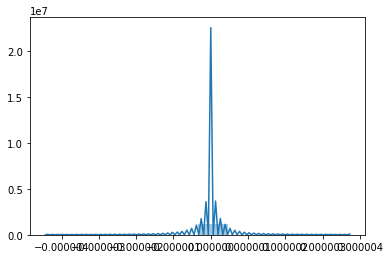

In [151]:
sns.distplot(lr_model.coef_, bins=10);

Let's see how many small small / big coefs there are

In [152]:
lr_coefs = np.array(lr_model.coef_)

In [153]:
print('Less than 1e-14: ', len(lr_coefs[0, lr_coefs[0, :] < 1e-14]))
print('More than 1e-5: ', len(lr_coefs[0, lr_coefs[0, :] > 1e-9]))

Less than 1e-14:  181
More than 1e-5:  123


Let's explore how removing these small coefs impacts the model

In [154]:
column_coefs_df = pd.DataFrame()
column_coefs_df['column'] = train_df.drop(columns=['isFraud']).columns
column_coefs_df['coef'] = lr_coefs[0, :]
print(column_coefs_df)

             column          coef
0     TransactionID -1.010086e-06
1     TransactionDT  1.533106e-09
2    TransactionAmt  2.264405e-11
3         ProductCD  3.181912e-08
4             card1 -4.434462e-06
5             card2  3.459304e-07
6             card3  3.284921e-08
7             card4 -2.494063e-09
8             card5  1.942292e-08
9             card6 -1.267535e-08
10            addr1 -8.247368e-08
11            addr2  1.965732e-08
12            dist1  8.493879e-09
13            dist2 -6.780214e-09
14    P_emaildomain -3.410104e-08
15    R_emaildomain  2.465734e-08
16               C1  1.718393e-11
17               C2  2.424026e-11
18               C3 -9.812866e-12
19               C4  8.758079e-12
20               C5 -3.459409e-12
21               C6  6.119719e-12
22               C7  7.337205e-12
23               C8  1.297256e-11
24               C9 -2.292339e-12
25              C10  1.135914e-11
26              C11  1.085470e-11
27              C12  1.176782e-11
28            

Let's identify features that have significant impact on the model - upper coefs

In [155]:
significant_features = column_coefs_df[column_coefs_df['coef'] > 2e-9]
significant_features

,column,coef
3,ProductCD,3.181912e-08
5,card2,3.459304e-07
6,card3,3.284921e-08
8,card5,1.942292e-08
11,addr2,1.965732e-08
12,dist1,8.493879e-09
15,R_emaildomain,2.465734e-08
31,D2,7.051367e-09
32,D3,4.099247e-09
37,D8,4.325927e-09


In [156]:
train_df_X = train_df[significant_features['column']]
train_df_y = train_df['isFraud']
train_X, test_X, train_y, test_y = train_test_split(train_df_X, train_df_y, test_size=.2)

In [157]:
lr_model = LogisticRegression(solver='saga', max_iter=100, n_jobs=-1, verbose=1)
lr_model.fit(train_X, train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


max_iter reached after 72 seconds


/home/simon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.2min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='saga', tol=0.0001,
          verbose=1, warm_start=False)

In [158]:
lr_model.score(test_X, test_y)

0.9649558031632065

### Predict frauds

In [159]:
test_df[significant_features['column']]

,ProductCD,card2,card3,card5,addr2,dist1,R_emaildomain,D2,D3,D8,...,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,8,0,4,0,0.000015,-1,0.006492,0.000418,0.000000,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,0,8,0,4,0,0.000062,-1,0.002309,0.000108,0.000000,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,0,322,0,4,0,0.040829,-1,0.002123,0.000155,0.000000,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,0,6,0,2,0,0.000263,-1,0.000651,0.000635,0.000000,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,0,30,0,3,0,0.000093,-1,0.000341,0.000000,0.000000,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
5,0,17,0,4,0,1.000000,-1,0.000558,0.000542,0.000000,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
6,0,47,0,29,0,1.000000,-1,1.000000,0.000000,0.000000,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
7,0,33,0,1,0,0.004695,-1,1.000000,1.000000,0.000000,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
8,0,7,0,4,0,0.000046,-1,0.001983,0.000201,0.000000,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
9,0,17,0,4,0,0.000124,-1,0.001069,0.000542,0.000000,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [160]:
predictions = lr_model.predict_proba(test_df[significant_features['column']])
print(predictions)

[[0.97343632 0.02656368]
 [0.96225033 0.03774967]
 [0.96918701 0.03081299]
 ...
 [0.9716007  0.0283993 ]
 [0.97716328 0.02283672]
 [0.92542035 0.07457965]]


### Display statistics

In [161]:
print('Test ROC AUC: ', roc_auc_score(test_y, test_predictions))
print('Test RMSE: ', math.sqrt(mean_squared_error(test_y, test_predictions)))
print('Score (Mean Accuracy): ', lr_model.score(test_X, test_y))

Test ROC AUC:  0.5
Test RMSE:  0.18715571907598655
Score (Mean Accuracy):  0.9649558031632065


The score was improved from 0.96471 to 0.0.96495

### Save submission data

In [163]:
submission_result = test_df.filter(items=['TransactionID']).copy()
submission_result['isFraud'] = predictions[:, 1]
submission_result[['TransactionID', 'isFraud']].to_csv(f'{ASSETS_PATH}submission-lr.csv', index=False)